# Vectorstores and Embeddings

Recall the overall workflow for retrieval augmented generation (RAG):

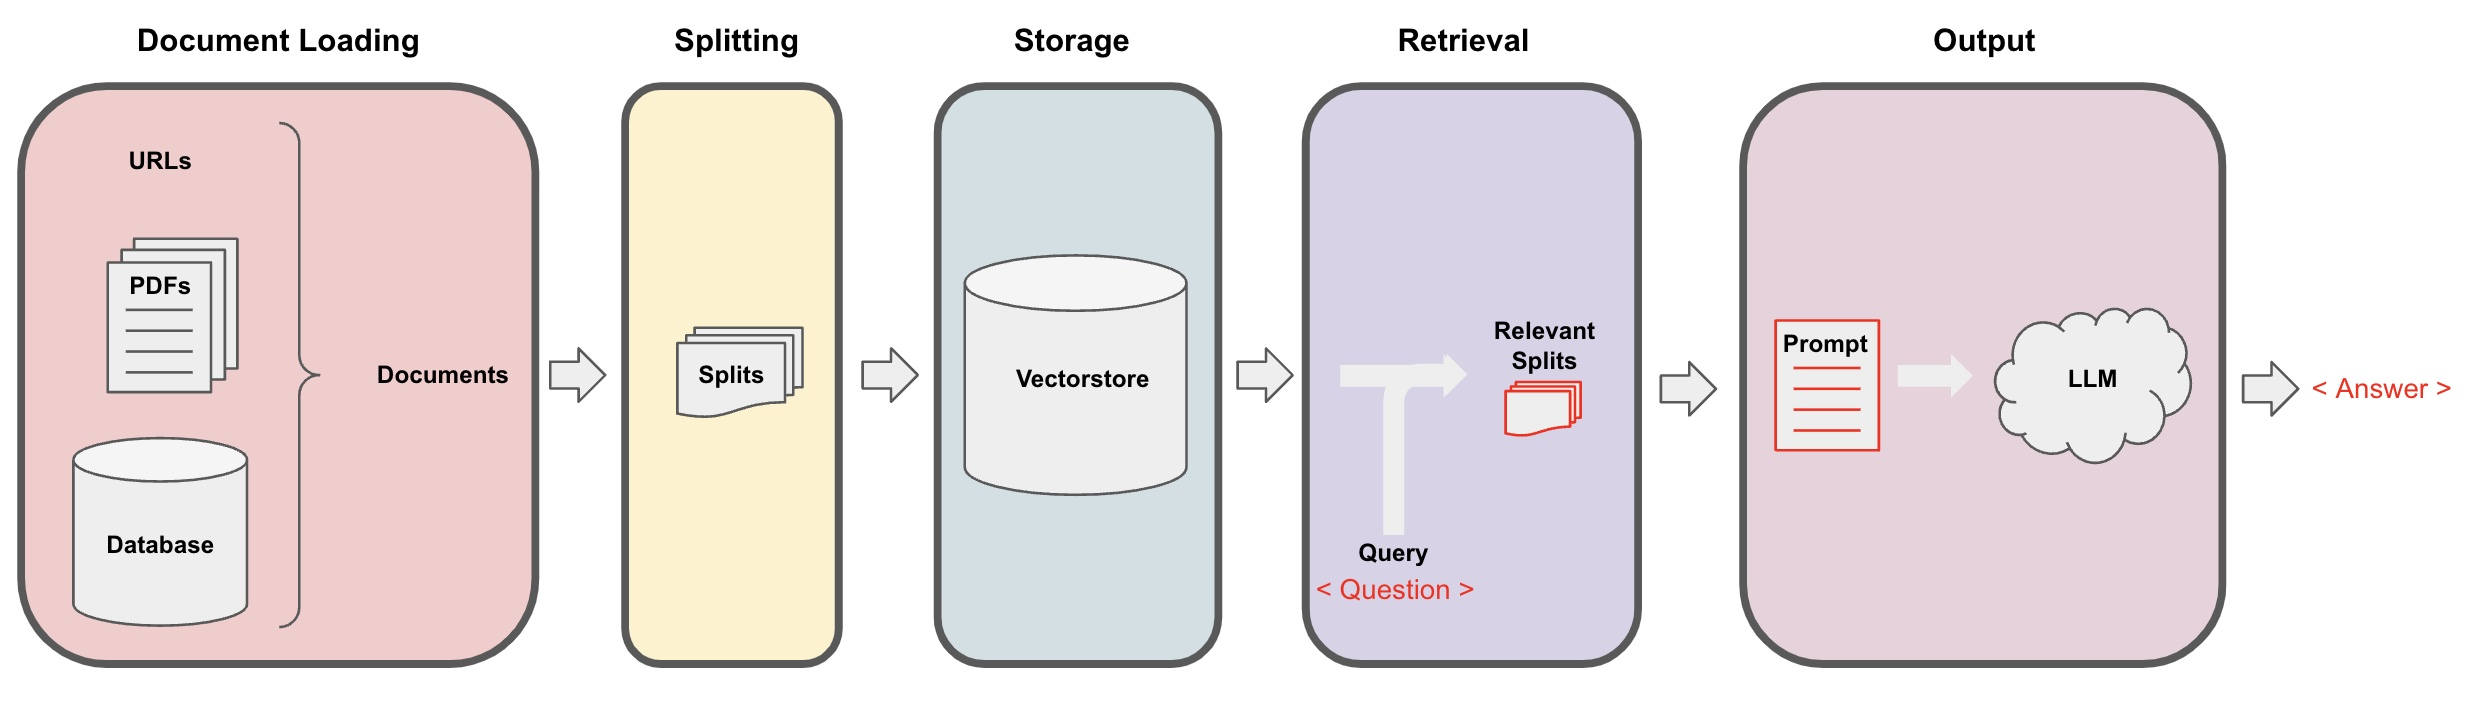

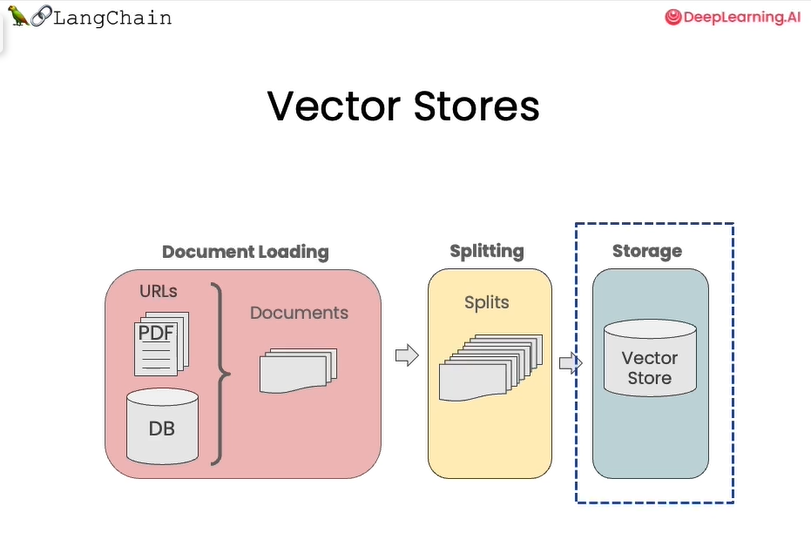

#######################################################################################################################

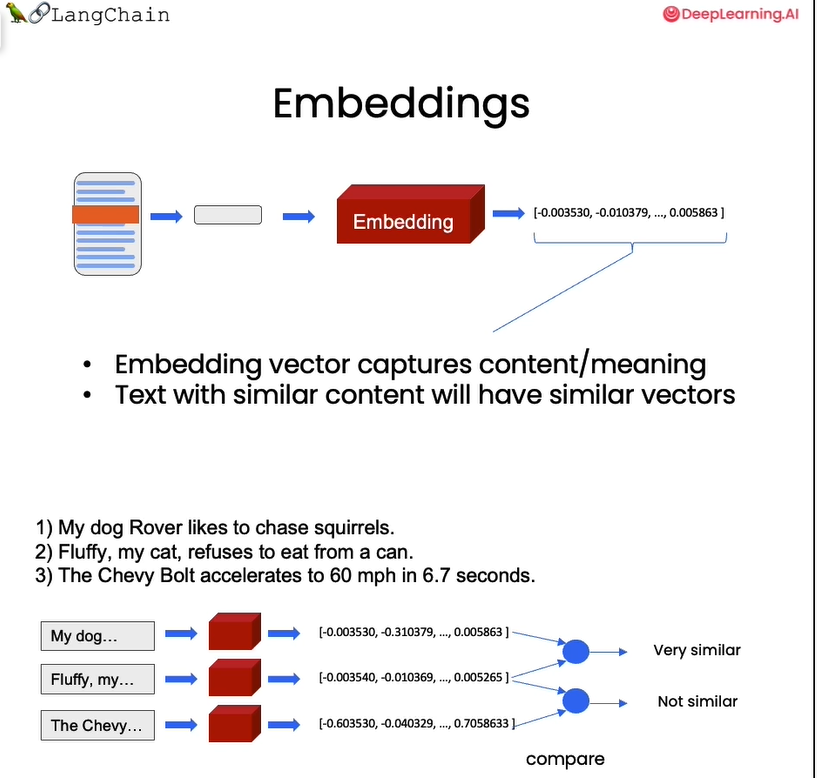

#######################################################################################################################

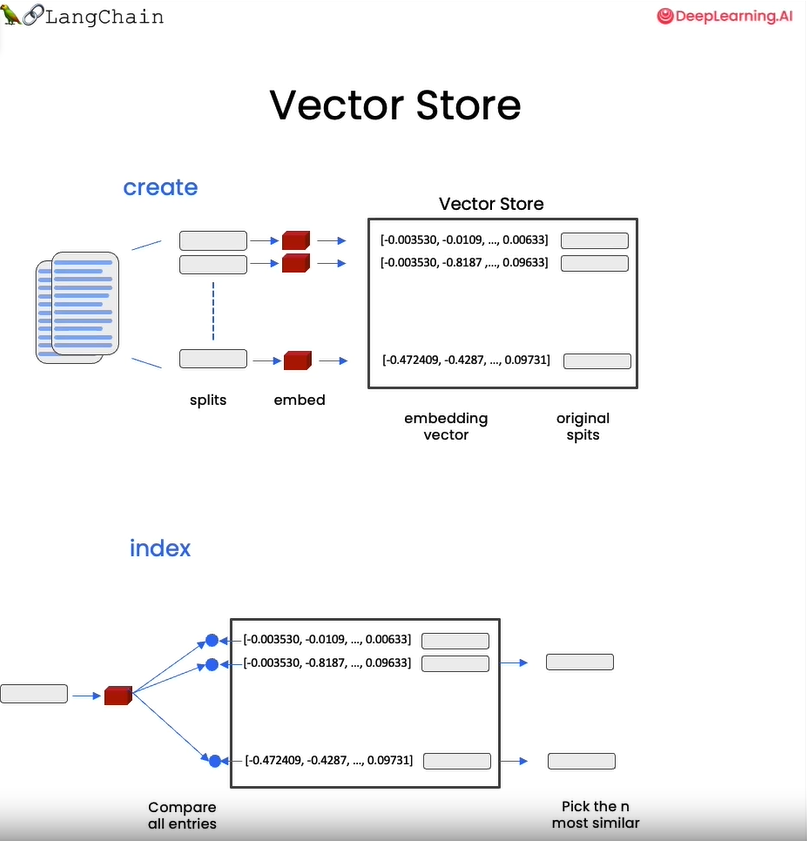

#######################################################################################################################

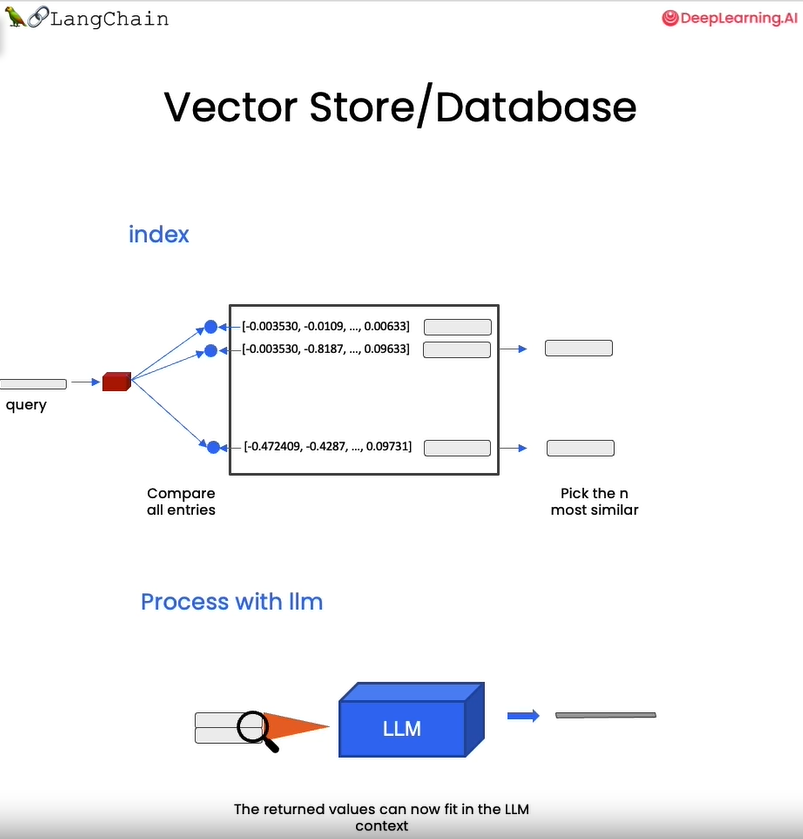

In [ ]:
import os
import openai
import sys
sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

We just discussed `Document Loading` and `Splitting`.

In [ ]:
from langchain.document_loaders import PyPDFLoader

# Load PDF
loaders = [
    # Duplicate documents on purpose - messy data
    PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture01.pdf"),
    PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture01.pdf"),
    PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture02.pdf"),
    PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture03.pdf")
]
docs = []
for loader in loaders:
    docs.extend(loader.load())

In [ ]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 150
)

In [ ]:
splits = text_splitter.split_documents(docs)

In [ ]:
len(splits)

## Embeddings

Let's take our splits and embed them.

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings()

In [ ]:
sentence1 = "i like dogs"
sentence2 = "i like canines"
sentence3 = "the weather is ugly outside"

In [ ]:
embedding1 = embedding.embed_query(sentence1)
embedding2 = embedding.embed_query(sentence2)
embedding3 = embedding.embed_query(sentence3)

In [ ]:
import numpy as np

In [ ]:
np.dot(embedding1, embedding2)

In [ ]:
np.dot(embedding1, embedding3)

In [ ]:
np.dot(embedding2, embedding3)

## Vectorstores

In [ ]:
# ! pip install chromadb

In [ ]:
from langchain.vectorstores import Chroma

In [ ]:
persist_directory = 'docs/chroma/'

In [ ]:
!rm -rf ./docs/chroma  # remove old database files if any

In [ ]:
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embedding,
    persist_directory=persist_directory
)

In [ ]:
print(vectordb._collection.count())

### Similarity Search

In [ ]:
question = "is there an email i can ask for help"

In [ ]:
docs = vectordb.similarity_search(question,k=3)

In [ ]:
len(docs)

In [ ]:
docs[0].page_content

Let's save this so we can use it later!

In [ ]:
vectordb.persist()

## Failure modes

This seems great, and basic similarity search will get you 80% of the way there very easily. 

But there are some failure modes that can creep up. 

Here are some edge cases that can arise - we'll fix them in the next class.

In [ ]:
question = "what did they say about matlab?"

In [ ]:
docs = vectordb.similarity_search(question,k=5)

Notice that we're getting duplicate chunks (because of the duplicate `MachineLearning-Lecture01.pdf` in the index).

Semantic search fetches all similar documents, but does not enforce diversity.

`docs[0]` and `docs[1]` are indentical.

In [ ]:
docs[0]

In [ ]:
docs[1]

We can see a new failure mode.

The question below asks a question about the third lecture, but includes results from other lectures as well.

In [ ]:
question = "what did they say about regression in the third lecture?"

In [ ]:
docs = vectordb.similarity_search(question,k=5)

In [ ]:
for doc in docs:
    print(doc.metadata)

In [ ]:
print(docs[4].page_content)

Approaches discussed in the next lecture can be used to address both!